Input Image:

In [20]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

input_image = Image.open("../input_images/house.jpg")
grayscale_image = input_image.convert('L')
image_array = np.array(grayscale_image)
height, width = image_array.shape

print(image_array)
print(f"Shape: {image_array.shape}")  #(height, width)

[[125 125 125 ...  91  91  91]
 [126 126 125 ...  91  91  91]
 [127 126 126 ...  92  92  92]
 ...
 [178 179 182 ...  62  62  62]
 [197 196 196 ...  74  74  75]
 [191 191 191 ...  66  67  67]]
Shape: (183, 275)


Save and Plot the results:

In [21]:
def show_results(output_array,output_image_name,input_image_array=input_image):
    Image.fromarray(output_array.astype(np.uint8)).save("../output_images/"+output_image_name+"_image.bmp")
    plt.figure(figsize=(10, 5))
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(np.array(input_image_array), cmap="gray")
    plt.title("Original Image", fontsize=16)
    plt.axis("off")
    # output Image
    plt.subplot(1, 2, 2)
    plt.imshow(output_array, cmap="gray")
    plt.title(output_image_name+" Image", fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("../output_images/"+output_image_name+"_result.png", dpi=300, bbox_inches='tight')
    plt.show()

Manual Technique:

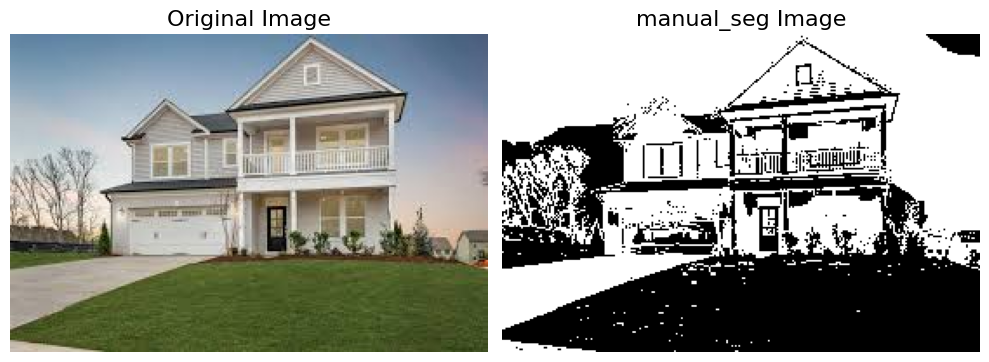

In [22]:
def manual_segmentation(image_array,low_threshold,High_threshold):
    #TODO : preprocessing
    output_array= np.zeros_like(image_array)
    output_array[(image_array>=low_threshold) & (image_array<=High_threshold)]= 255
    return output_array

show_results(output_array=manual_segmentation(image_array, 100, 200), output_image_name="manual_seg")

Histogram Peak Technique:

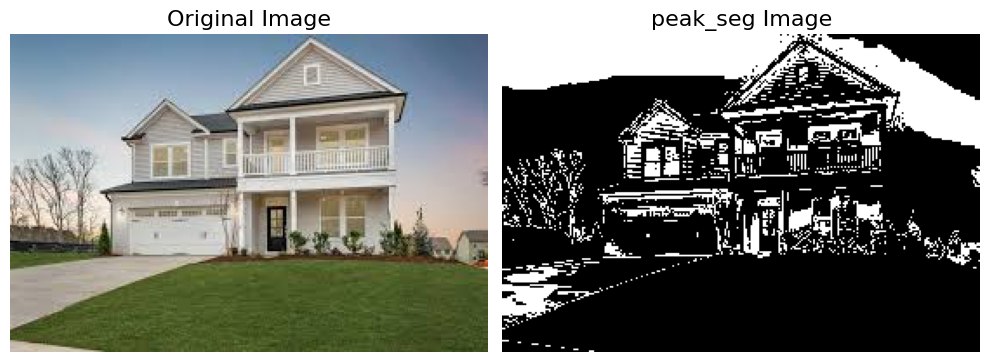

In [23]:
def peak_segmentation(image_array):
    #TODO : preprocessing
    hist = apply_histogram(image_array)
    peaks=find_highest_peaks(hist)
    #print([peaks])
    low_threshold, high_threshold = compute_thresholds(peaks)
    #print([low_threshold, high_threshold])
    output_array = np.zeros_like(image_array, dtype=int)
    output_array[(image_array >= low_threshold) & (image_array <= high_threshold)] = 255
    return output_array

def apply_histogram(image_array):
    height, width = image_array.shape
    histogram_array = np.zeros(256, dtype=int)
    for row in range(height):
        for column in range(width):
            pixel_value = image_array[row,column]
            histogram_array[pixel_value]+=1
    return histogram_array

def find_highest_peaks(hist, min_distance=10):
    peaks = []
    for i in range(1, len(hist) - 1):
        if hist[i] > hist[i - 1] and hist[i] > hist[i + 1]:
            peaks.append(i)
    sorted_peaks = sorted(peaks, key=lambda x: hist[x], reverse=True)
    filtered_peaks = []
    for peak in sorted_peaks:
        if all(abs(peak - existing_peak) >= min_distance for existing_peak in filtered_peaks):
            filtered_peaks.append(peak)
    return filtered_peaks[:2]

def compute_thresholds(peaks):#peak only
    if len(peaks) >= 2:
        peak_back=peaks[0]
        peak_object=peaks[1]
        low_threshold=(peak_back+peak_object)//2
        high_threshold = peak_object
        return low_threshold, high_threshold
    
show_results(output_array=peak_segmentation(image_array), output_image_name="peak_seg")

Histogram Valley Technique:

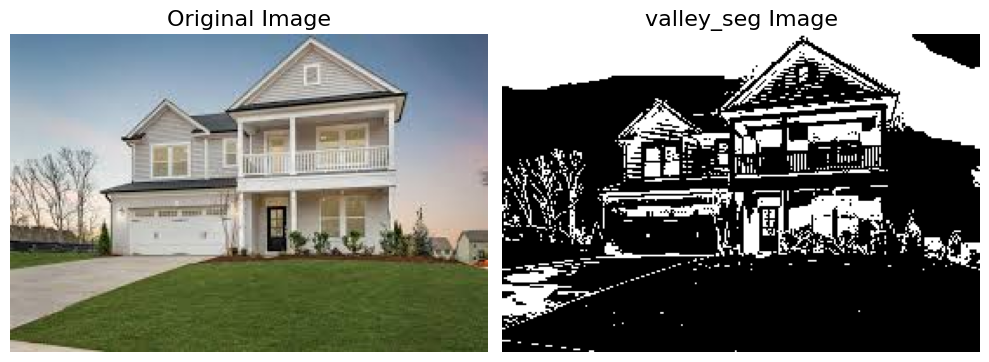

In [24]:
def valley_segmentation(image_array):
    #TODO : preprocessing
    output_array= np.zeros_like(image_array)
    hist = apply_histogram(image_array)
    peaks=find_highest_peaks(hist)
    #print([peaks])
    low_threshold, high_threshold = valley_thresholds(peaks,find_valley_point(peaks,hist))
    #print([low_threshold, high_threshold])
    output_array[(image_array >= low_threshold) & (image_array <= high_threshold)] = 255
    return output_array

def find_valley_point(peaks_indices,hist):
    if len(peaks_indices) < 2:
        raise ValueError("At least two peaks required.")
    min_valley=float('inf')
    peaks_indices = sorted(peaks_indices)
    start,end = peaks_indices
    valley_point=start
    for i in range(start,end+1):
        if hist[i]<min_valley:
            min_valley=hist[i]
            valley_point=i
    return valley_point

def valley_thresholds(peaks_indices,valley_point):
    if len(peaks_indices) >= 2:
        low_threshold = valley_point
        high_threshold = peaks_indices[1]
    return low_threshold, high_threshold 

show_results(output_array=valley_segmentation(image_array), output_image_name="valley_seg")

Adaptive Histogram Technique:

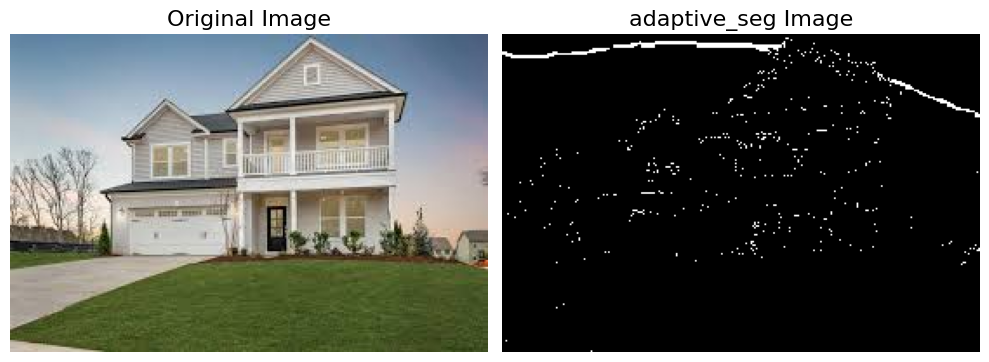

In [25]:
def adaptive_segmentation(image_array):
    #TODO : preprocessing
    hist = apply_histogram(image_array)
    peaks=find_highest_peaks(hist)
    low_threshold, high_threshold = valley_thresholds(peaks,find_valley_point(peaks,hist))
    #print([low_threshold, high_threshold])
    output_array= np.zeros_like(image_array)
    output_array[(image_array >= low_threshold) & (image_array <= high_threshold)] = 255
    background_mean, object_mean = calculate_means(output_array, image_array)
    new_peaks_indices = [int(background_mean), int(object_mean)]
    new_low_threshold, new_high_threshold = valley_thresholds(new_peaks_indices,find_valley_point(new_peaks_indices,hist))
    #print([new_low_threshold, new_high_threshold])
    final_image_array = np.zeros_like(image_array)
    final_image_array[(image_array >= new_low_threshold) & (image_array <= new_high_threshold)] = 255
    return final_image_array

def calculate_means(segmented_image, original_image):
    object_pixels = original_image[segmented_image == 255]
    background_pixels = original_image[segmented_image == 0]
    object_mean = object_pixels.mean() if object_pixels.size > 0 else 0
    background_mean = background_pixels.mean() if background_pixels.size > 0 else 0
    return background_mean, object_mean

show_results(output_array=adaptive_segmentation(image_array), output_image_name="adaptive_seg")